In [1]:
import json
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Torch
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset

In [2]:
# model
from model import LTSFLinear

In [3]:
warnings.filterwarnings("ignore")

In [4]:
BATCH_SIZE = 8
WINDOWS_SIZE = 60
EPOCHS = 20
TRAIN_TEST_SPLIT = 0.8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = f"basic_ltsf_linear_wd{WINDOWS_SIZE}"

## Data processing

In [5]:
df = pd.read_csv('./data/agg_data.csv')
df.columns

Index(['StnPres', 'SeaPres', 'StnPresMax', 'StnPresMaxTime', 'StnPresMin',
       'StnPresMinTime', 'Temperature', 'T Max', 'T Max Time', 'T Min',
       'T Min Time', 'Td dew point', 'RH', 'RHMin', 'RHMinTime', 'WS', 'WD',
       'WSGust', 'WDGust', 'WGustTime', 'Precp', 'PrecpHour', 'PrecpMax10',
       'PrecpMax10Time', 'PrecpMax60', 'PrecpMax60Time', 'SunShine',
       'SunshineRate', 'GloblRad', 'VisbMean', 'EvapA', 'UVI Max',
       'UVI Max Time', 'Cloud Amount', 'TxSoil0cm', 'TxSoil5cm', 'TxSoil10cm',
       'TxSoil20cm', 'TxSoil30cm', 'TxSoil50cm', 'TxSoil100cm'],
      dtype='object')

In [6]:
DROP_COL = ["StnPresMaxTime","StnPresMinTime","T Max Time","UVI Max Time","T Min Time","RHMinTime","WGustTime","PrecpMax10Time","PrecpMax60Time"]
df = df.drop(DROP_COL, axis=1)

In [7]:
df['EvapA'] = df['EvapA'].replace('/', 0)
df['EvapA'] = df['EvapA'].astype(float)
df['Precp'] = df['Precp'].replace('T', 0)
df['Precp'] = df['Precp'].astype(float)
df['UVI Max'] = df['UVI Max'].replace('X', 0)
df['UVI Max'] = df['UVI Max'].astype(float)
df['PrecpMax10'] = df['PrecpMax10'].replace('T', 0)
df['PrecpMax10'] = df['PrecpMax10'].astype(float)
df['PrecpMax60'] = df['PrecpMax60'].replace('T', 0)
df['PrecpMax60'] = df['PrecpMax60'].astype(float)

In [8]:
df.head()

,StnPres,SeaPres,StnPresMax,StnPresMin,Temperature,T Max,T Min,Td dew point,RH,RHMin,...,EvapA,UVI Max,Cloud Amount,TxSoil0cm,TxSoil5cm,TxSoil10cm,TxSoil20cm,TxSoil30cm,TxSoil50cm,TxSoil100cm
0,995.6,998.0,997.6,994.0,28.3,31.8,26.7,24.5,80,66,...,-2.3,6.0,9.7,28.1,28.1,28.5,28.7,29.8,29.4,29.1
1,996.0,998.4,997.2,995.0,27.4,29.7,25.1,24.7,86,75,...,-3.1,9.0,8.7,27.4,27.6,28.1,28.4,29.5,29.2,29.1
2,996.4,998.8,998.0,994.7,28.0,30.3,26.2,25.7,87,78,...,4.3,10.0,8.3,28.0,28.0,28.2,28.3,29.3,28.9,29.0
3,997.6,1000.0,998.7,996.2,28.4,32.7,26.3,25.4,85,63,...,-4.1,13.0,8.7,28.4,28.2,28.5,28.5,29.5,28.9,28.9
4,996.8,999.2,997.7,995.8,27.1,30.3,25.7,25.7,92,77,...,-0.5,5.0,8.7,27.5,27.8,28.2,28.4,29.4,29.0,28.8


In [9]:
TARGET = "Temperature"

# Make dataset

In [10]:
class WeatherDataset(Dataset):
    def __init__(self, df, target, window_size=30):
        self.df = df
        self.target = target
        self.window_size = window_size
        self.features = df.columns

    def __len__(self):
        return len(self.df) - self.window_size - 1
    
    def __getitem__(self, idx):
        idx += self.window_size
        window = self.df.iloc[idx-self.window_size:idx]
        target = self.df.iloc[idx+1][self.target]
        features = window[self.features].values
        return features, target
    
dataset = WeatherDataset(df, TARGET, window_size=WINDOWS_SIZE)
train_size = int(TRAIN_TEST_SPLIT * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
for idx,(features, target) in enumerate(train_dataloader):
    print(f"Input Shape: {features.shape}, Target Shape: {target.shape}")
    break

Input Shape: torch.Size([8, 60, 32]), Target Shape: torch.Size([8])


In [12]:
# Model
# class WeatherModel(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(WeatherModel, self).__init__()
#         self.transformer = nn.Transformer(d_model=input_size, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=512, dropout=0.1)
#         self.fc = nn.Linear(input_size, output_size)
        
#     def forward(self, x):
#         x = self.transformer(x, x)
#         x = self.fc(x)
#         x = x[:, -1]
#         return x

class WeatherModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(WeatherModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

class WeatherModel_with_LTSF(nn.Module):
    def __init__(self, seq_len, pred_len, enc_in):
        super(WeatherModel_with_LTSF, self).__init__()
        self.LTSF = LTSFLinear(configs={"seq_len": seq_len, "pred_len": pred_len, "enc_in": enc_in, "individual": False})
        self.linear = nn.Linear(enc_in, 1)

    def forward(self, x):
        x = self.LTSF(x)
        x = x.squeeze(1)
        x = F.gelu(x)
        x = self.linear(x)
        return x
    
class WeatherModel_Mix(nn.Module):
    def __init__(self, seq_len, pred_len, enc_in):
        super(WeatherModel_Mix, self).__init__()
        # LTSF 模型
        self.LTSF = LTSFLinear(configs={"seq_len": seq_len, "pred_len": pred_len, "enc_in": enc_in, "individual": False})
        self.LTSF_linear = nn.Linear(enc_in, 1)
        
        # LSTM 模型
        self.LSTM = nn.LSTM(enc_in, 64, batch_first=True)
        self.LSTM_linear = nn.Linear(64, 1)
        
        # Combine 模型
        self.combine_linear = nn.Linear(3, 1)

    def forward(self, x):
        # LTSF 模型預測
        x_LTSF = self.LTSF(x)
        x_LTSF = x_LTSF.squeeze(1)  # 去掉維度1
        x_LTSF = F.gelu(x_LTSF)
        x_LTSF = self.LTSF_linear(x_LTSF)
        
        # LSTM 模型預測
        x_LSTM, _ = self.LSTM(x)
        x_LSTM = x_LSTM[:, -1, :]  # 取序列最後一個時間步的輸出
        x_LSTM = self.LSTM_linear(x_LSTM)
        
        # 融合兩個模型的預測結果
        x_diff = torch.abs(x_LTSF - x_LSTM)
        x_combined = torch.cat([x_LTSF, x_LSTM, x_diff], dim=1)
        x_combined = self.combine_linear(x_combined)
        
        return x_combined
    
test_input = torch.randn(8, WINDOWS_SIZE, 32)
# model = WeatherModel(WINDOWS_SIZE, 64, 1)
model = WeatherModel_with_LTSF(WINDOWS_SIZE, 1, 32)
# model = WeatherModel_Mix(WINDOWS_SIZE, 1, 32)
out = model(test_input)
print(out.shape)

torch.Size([8, 1])


In [13]:
# model = WeatherModel(len(df.columns), 64, 1).to(DEVICE)
model = WeatherModel_with_LTSF(WINDOWS_SIZE, 1, 32).to(DEVICE)
# model = WeatherModel_Mix(WINDOWS_SIZE, 1, 32).to(DEVICE)

# Loss and Optimizer

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training

def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        features, target = data
        features, target = features.float().to(DEVICE), target.float().to(DEVICE)
        optimizer.zero_grad()
        output = model(features)
        loss = criterion(output, target.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

def test(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            features, target = data
            features, target = features.float().to(DEVICE), target.float().to(DEVICE)
            output = model(features)
            loss = criterion(output, target.unsqueeze(1))
            running_loss += loss.item()
    return running_loss / len(dataloader)

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    train_loss = train(model, train_dataloader, criterion, optimizer)
    test_loss = test(model, test_dataloader, criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f"Epoch: {epoch+1}/{EPOCHS}, Train Loss: {train_loss}, Test Loss: {test_loss}")

Epoch: 1/20, Train Loss: 520.0518727857013, Test Loss: 539.9476720636541
Epoch: 2/20, Train Loss: 504.8505579039108, Test Loss: 532.7521625865589
Epoch: 3/20, Train Loss: 496.6870748830396, Test Loss: 521.6844870827415
Epoch: 4/20, Train Loss: 484.6028346571811, Test Loss: 506.44809514825994
Epoch: 5/20, Train Loss: 448.47313690185547, Test Loss: 285.6495638760653
Epoch: 6/20, Train Loss: 45.44840084674747, Test Loss: 29.439398071982644
Epoch: 7/20, Train Loss: 22.18729844481446, Test Loss: 20.57775115966797
Epoch: 8/20, Train Loss: 15.961565882660622, Test Loss: 18.472801598635588
Epoch: 9/20, Train Loss: 13.17112339374631, Test Loss: 14.008646255189722
Epoch: 10/20, Train Loss: 13.552662091199743, Test Loss: 12.84178758209402
Epoch: 11/20, Train Loss: 10.966407606768053, Test Loss: 14.554013772444291
Epoch: 12/20, Train Loss: 9.957028824229573, Test Loss: 15.914889574050903
Epoch: 13/20, Train Loss: 9.716235078351442, Test Loss: 8.836363868279891
Epoch: 14/20, Train Loss: 9.652552962

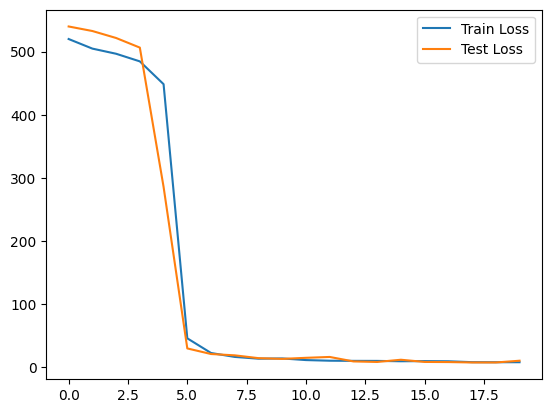

In [14]:
# plot
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()

In [15]:
# predict
def predict(model, df, window_size=30):
    model.eval()
    features = df.iloc[-window_size:].values
    features = torch.tensor(features).float().to(DEVICE)
    with torch.no_grad():
        pred = model(features.unsqueeze(0))
    return pred.item()

predict(model, df, window_size=WINDOWS_SIZE)

13.006299018859863

In [16]:
from math import sqrt
latest_test_loss = test_losses[-1]
print(f"error of prediction temperature: +- {sqrt(latest_test_loss)}")

error of prediction temperature: +- 3.1534743856032588


In [17]:
# save json
info = {
    "model_name": MODEL_NAME,
    "target": TARGET,
    "features": df.columns.tolist(),
    "window_size": WINDOWS_SIZE,
    "train_test_split": TRAIN_TEST_SPLIT,
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    "device": DEVICE.type,
    "train_loss": train_losses,
    "test_loss": test_losses
}

with open(f"results/{MODEL_NAME}.json", "w") as f:
    json.dump(info, f)